In [1]:
import os
import hashlib
import requests
import zipfile
import tarfile
import matplotlib.pyplot as plt
import collections
import torch
from torch import nn
from torch.utils import data
import numpy as np
import time
from IPython import display
import math

## 编码器

In [2]:
class Encoder(nn.Module):
    """编码器-解码器架构的基本编码器接口"""
    def __init__(self, **kwargs):
        super(Encoder, self).__init__(**kwargs)
    def forward(self, X, *args):
        raise NotImplementedError

In [3]:
class Seq2SeqEncoder(Encoder):
    """用于序列到序列学习的循环神经网络编码器"""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout=0, **kwargs):
        super(Seq2SeqEncoder, self).__init__(**kwargs)
        ## 嵌入层
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size, num_hiddens, num_layers, dropout=dropout)
    def forward(self, X, *args):
        
        X = self.embedding(X)   ## 输出X的形状 (batch_size, num_steps, embed_size)
        X = X.permute(1, 0, 2)  ## 在循环神经网络模型中,第一个轴对应时间步
        output, state = self.rnn(X)
        return (output, state)


In [4]:
"""example
X = torch.arange(24).reshape(2,3,4)
permute_X = X.permute(1, 0, 2)
transpose_X = X.transpose(1, 0)
X, permute_X, transpose_X
"""
"""output
(tensor([[[ 0,  1,  2,  3],
          [ 4,  5,  6,  7],
          [ 8,  9, 10, 11]],
 
         [[12, 13, 14, 15],
          [16, 17, 18, 19],
          [20, 21, 22, 23]]]),
 tensor([[[ 0,  1,  2,  3],
          [12, 13, 14, 15]],
 
         [[ 4,  5,  6,  7],
          [16, 17, 18, 19]],
 
         [[ 8,  9, 10, 11],
          [20, 21, 22, 23]]]),
 tensor([[[ 0,  1,  2,  3],
          [12, 13, 14, 15]],
 
         [[ 4,  5,  6,  7],
          [16, 17, 18, 19]],
 
         [[ 8,  9, 10, 11],
          [20, 21, 22, 23]]]))
"""

'output\n(tensor([[[ 0,  1,  2,  3],\n          [ 4,  5,  6,  7],\n          [ 8,  9, 10, 11]],\n \n         [[12, 13, 14, 15],\n          [16, 17, 18, 19],\n          [20, 21, 22, 23]]]),\n tensor([[[ 0,  1,  2,  3],\n          [12, 13, 14, 15]],\n \n         [[ 4,  5,  6,  7],\n          [16, 17, 18, 19]],\n \n         [[ 8,  9, 10, 11],\n          [20, 21, 22, 23]]]),\n tensor([[[ 0,  1,  2,  3],\n          [12, 13, 14, 15]],\n \n         [[ 4,  5,  6,  7],\n          [16, 17, 18, 19]],\n \n         [[ 8,  9, 10, 11],\n          [20, 21, 22, 23]]]))\n'

In [5]:
encoder = Seq2SeqEncoder(
    vocab_size=10,
    embed_size=8,
    num_hiddens=16,
    num_layers=2
)
encoder.eval()
X = torch.zeros((4, 7), dtype=torch.long)
output, state = encoder(X)
output.shape, state.shape   ## state的shape为(隐藏层数量，批量大小，隐藏单元数量)

(torch.Size([7, 4, 16]), torch.Size([2, 4, 16]))

## 解码器

In [6]:
class Decoder(nn.Module):
    def __init__(self, **kwargs):
        super(Decoder, self).__init__(**kwargs)
    def init_state(self, enc_outputs, *args):
        raise NotImplementedError
    def forward(self, X, state):
        raise NotImplementedError

In [7]:
class Seq2SeqDecoder(Decoder):
    """用于序列到序列学习的循环神经网络解码器"""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout=0, **kwargs):
        super(Seq2SeqDecoder, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size+num_hiddens, num_hiddens, num_layers, dropout=dropout)
        self.dense = nn.Linear(num_hiddens, vocab_size)
    def init_state(self, enc_outputs, *args):
        return enc_outputs[1]
    def forward(self, X, state):
        X = self.embedding(X).permute(1, 0, 2)
        context = state[-1].repeat(X.shape[0], 1, 1)
        X_and_context = torch.cat((X, context), 2)
        output, state = self.rnn(X_and_context, state)
        output = self.dense(output).permute(1, 0, 2)
        return output, state

In [9]:
"""example
a = torch.arange(12).reshape(3,4)
a.repeat(2,1,1)
"""
"""output
tensor([[[ 0,  1,  2,  3],
         [ 4,  5,  6,  7],
         [ 8,  9, 10, 11]],

        [[ 0,  1,  2,  3],
         [ 4,  5,  6,  7],
         [ 8,  9, 10, 11]]])
"""

'output\ntensor([[[ 0,  1,  2,  3],\n         [ 4,  5,  6,  7],\n         [ 8,  9, 10, 11]],\n\n        [[ 0,  1,  2,  3],\n         [ 4,  5,  6,  7],\n         [ 8,  9, 10, 11]]])\n'

In [140]:
"""example
a = torch.arange(12).reshape(1, 3, 4)
a, a.repeat(2, 1, 1), a.repeat(2, 2, 1) 
"""
"""output
(tensor([[[ 0,  1,  2,  3],
          [ 4,  5,  6,  7],
          [ 8,  9, 10, 11]]]),
 tensor([[[ 0,  1,  2,  3],
          [ 4,  5,  6,  7],
          [ 8,  9, 10, 11]],
 
         [[ 0,  1,  2,  3],
          [ 4,  5,  6,  7],
          [ 8,  9, 10, 11]]]),
 tensor([[[ 0,  1,  2,  3],
          [ 4,  5,  6,  7],
          [ 8,  9, 10, 11],
          [ 0,  1,  2,  3],
          [ 4,  5,  6,  7],
          [ 8,  9, 10, 11]],
 
         [[ 0,  1,  2,  3],
          [ 4,  5,  6,  7],
          [ 8,  9, 10, 11],
          [ 0,  1,  2,  3],
          [ 4,  5,  6,  7],
          [ 8,  9, 10, 11]]]))
"""

'output\n(tensor([[[ 0,  1,  2,  3],\n          [ 4,  5,  6,  7],\n          [ 8,  9, 10, 11]]]),\n tensor([[[ 0,  1,  2,  3],\n          [ 4,  5,  6,  7],\n          [ 8,  9, 10, 11]],\n \n         [[ 0,  1,  2,  3],\n          [ 4,  5,  6,  7],\n          [ 8,  9, 10, 11]]]),\n tensor([[[ 0,  1,  2,  3],\n          [ 4,  5,  6,  7],\n          [ 8,  9, 10, 11],\n          [ 0,  1,  2,  3],\n          [ 4,  5,  6,  7],\n          [ 8,  9, 10, 11]],\n \n         [[ 0,  1,  2,  3],\n          [ 4,  5,  6,  7],\n          [ 8,  9, 10, 11],\n          [ 0,  1,  2,  3],\n          [ 4,  5,  6,  7],\n          [ 8,  9, 10, 11]]]))\n'

In [141]:
decoder = Seq2SeqDecoder(vocab_size=10, embed_size=8, num_hiddens=16, num_layers=2)
decoder.eval()
state = decoder.init_state(encoder(X))
output, state = decoder(X, state)
output.shape, state.shape

(torch.Size([4, 7, 10]), torch.Size([2, 4, 16]))

## 损失函数

In [142]:
def sequence_mask(X, valid_len, value=0):
    """在序列中遮蔽不相关的项"""
    maxlen = X.size(1)
    mask = torch.arange((maxlen), dtype=torch.float32, device=X.device)[None,:] < valid_len[:, None]
    X[~mask] = value
    return X

In [143]:
"""example
a = torch.arange(12)[None,:]
a
"""
"""output
tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]])
"""

'output\ntensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]])\n'

In [144]:
"""example
a = torch.arange(12).reshape(2,6)
a[0] = -1
a
"""
"""output
tensor([[-1, -1, -1, -1, -1, -1],
        [ 6,  7,  8,  9, 10, 11]])
"""

'output\ntensor([[-1, -1, -1, -1, -1, -1],\n        [ 6,  7,  8,  9, 10, 11]])\n'

In [145]:
X = torch.tensor([[1,2,3],[4,5,6]])
sequence_mask(X, torch.tensor([1,2]))

tensor([[1, 0, 0],
        [4, 5, 0]])

In [146]:
X = torch.ones(2,3,4)
sequence_mask(X, torch.tensor([1,2]), value=-1)

tensor([[[ 1.,  1.,  1.,  1.],
         [-1., -1., -1., -1.],
         [-1., -1., -1., -1.]],

        [[ 1.,  1.,  1.,  1.],
         [ 1.,  1.,  1.,  1.],
         [-1., -1., -1., -1.]]])

In [147]:
class MaskedSoftmaxCELoss(nn.CrossEntropyLoss):
    """带遮蔽的softmax交叉熵损失函数"""
    ## pred      --> (batch_size, num_steps, vocab_size)
    ## label     --> (batch_size, num_steps)
    ## valid_len --> (batch_size, )
    def forward(self, pred, label, valid_len):
        weights = torch.ones_like(label)
        weights = sequence_mask(weights, valid_len)
        self.reduction = 'none'
        unweighted_loss = super(MaskedSoftmaxCELoss, self).forward(
            pred.permute(0, 2, 1), label
        )
        weighted_loss = (unweighted_loss * weights).mean(dim=1)
        return weighted_loss


In [148]:
loss = MaskedSoftmaxCELoss()
loss(torch.ones(3, 4, 10), torch.ones((3,4), dtype=torch.long), torch.tensor([4,2,0]))

tensor([2.3026, 1.1513, 0.0000])

## 训练

In [149]:
DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

In [150]:
def download_dataset(name, cache_dir=None):
    """下载一个DATA_HUB中的文件,返回本地文件名"""
    assert name in DATA_HUB, f"{name} not in {DATA_HUB}"
    cache_dir = os.path.join('..', 'data') if cache_dir is None else cache_dir
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
            if sha1.hexdigest() == sha1_hash:
                return fname
    print(f"Downloading {name} from {url} to {fname}...")
    raw_data = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(raw_data.content)
    return fname


In [151]:
def download_dataset_and_extract(name, folder=None):
    """下载并解压zip/tar文件"""
    fname = download_dataset(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    match ext:
        case '.zip':
            fp = zipfile.ZipFile(fname, 'r')
        case '.tar', '.gz':
            fp = tarfile.open(fname, 'r')
        case _:
            assert False, f'不支持的文件类型：{ext}'
    fp.extractall(path=base_dir)
    fp.close()
    return os.path.join(base_dir, folder) if folder else data_dir

def download_all_datasets():
    """下载DATA_HUB中的所有数据集"""
    for name in DATA_HUB:
        download_dataset(name)
    

In [152]:
DATA_HUB['fra-eng'] = (DATA_URL + 'fra-eng.zip',
                       '94646ad1522d915e7b0f9296181140edcf86a4f5')

In [153]:
def read_data_nmt():
    """载入'英语-法语'数据集"""
    data_dir = download_dataset_and_extract('fra-eng')
    with open(os.path.join(data_dir, 'fra.txt'), 'r', encoding='utf-8') as f:
        return f.read()

In [154]:
def preprocess_nmt(text):
    """预处理'英语-法语'数据集"""
    def no_space(char, prev_char):
        return char in set(',.!?') and prev_char != ' '
    ## 使用空格替换不间断空格，使用小写字母替换大写字母
    text = text.replace('\u202f', ' ').replace('\xa0', ' ').lower()
    ## 在单词和标点符号之间插入空格
    out = [' ' + char if i > 0 and no_space(char, text[i-1]) else char for i, char in enumerate(text)]
    return ''.join(out)

In [155]:
def tokenize_nmt(text, num_examples=None):
    """词元化'英语-法语'数据数据集"""
    source, target = [], []
    for i, line in enumerate(text.split('\n')):
        if num_examples and i > num_examples:
            break
        parts = line.split('\t')
        if len(parts) == 2:
            source.append(parts[0].split(' '))
            target.append(parts[1].split(' '))
    return source, target

In [156]:
class Vocab:
    """文本词表"""
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        tokens = [] if tokens is None else tokens
        reserved_tokens = [] if reserved_tokens is None else reserved_tokens
        ## 按出现频率排序
        counter = Vocab.count_corpus(tokens)
        self._token_freqs = sorted(counter.items(), key=lambda x: x[1], reverse=True)
        self.idx2token = ['<unk>'] + reserved_tokens
        self.token2idx = {token: idx for idx, token in enumerate(self.idx2token)}
        for token, freq in self._token_freqs:
            if freq < min_freq:
                break
            if token not in self.token2idx:
                self.idx2token.append(token)
                self.token2idx[token] = len(self.idx2token)-1
    def __len__(self):
        return len(self.idx2token)
    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token2idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]
    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx2token[indices]
        return [self.idx2token[index] for index in indices]
    @property
    def unk(self):
        return 0
    @property
    def token_freqs(self):
        return self._token_freqs 
    @staticmethod
    def count_corpus(tokens):
        """统计词元频率"""
        if isinstance(tokens[0], list):
            tokens = [token for line in tokens for token in line]
        return collections.Counter(tokens)
  

In [157]:
def truncate_pad(line, num_steps, padding_token):
    """截断或填充文本序列"""
    if len(line) > num_steps:
        return line[:num_steps]
    return line + [padding_token]*(num_steps-len(line))

In [158]:
def build_array_nmt(lines, vocab, num_steps):
    """将机器翻译的文本序列转换成小批量"""
    lines = [vocab[l] for l in lines]
    lines = [l + [vocab['<eos>']] for l in lines]
    array = torch.tensor(
        [truncate_pad(l, num_steps, vocab['<pad>']) for l in lines]
    )
    valid_len = (array != vocab['<pad>']).type(torch.int32).sum(1)
    return array, valid_len

In [159]:
def load_array(data_arrays, batch_size, is_train=True):
    """构造一个PyTorch数据迭代器"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size=batch_size, shuffle=is_train)

In [160]:
def load_data_nmt(batch_size, num_steps, num_examples=600):
    """返回翻译数据集的迭代器和词表"""
    text = preprocess_nmt(read_data_nmt())
    source, target = tokenize_nmt(text, num_examples)
    src_vocab = Vocab(source, min_freq=2, reserved_tokens=['<pad>', '<bos>', '<eos>'])
    tgt_vocab = Vocab(target, min_freq=2, reserved_tokens=['<pad>', '<bos>', '<eos>'])
    src_array, src_valid_len = build_array_nmt(source, src_vocab, num_steps)
    tgt_array, tgt_valid_len = build_array_nmt(target, tgt_vocab, num_steps)
    data_arrays = (src_array, src_valid_len, tgt_array, tgt_valid_len)
    data_iter = load_array(data_arrays, batch_size=batch_size)
    return data_iter, src_vocab, tgt_vocab

In [161]:
class Timer:
    """记录多次运行时间"""
    def __init__(self):
        self.times = []
        self.start()
    def start(self):
        """启动计时器"""
        self.tik = time.time()
    def stop(self):
        """停止计时器并将时间记录在列表中"""
        self.times.append(time.time() - self.tik)
        return self.times[-1]
    def avg(self):
        """返回平均时间"""
        return sum(self.times) / len(self.times)
    def sum(self):
        """返回时间总和"""
        return sum(self.times)
    def cumsum(self):
        """返回累计时间"""
        return np.cumsum(self.times).tolist()

In [162]:
class Accumulator:
    def __init__(self, n):
        self.data = [.0] * n
    def add(self, *args):
        self.data = [a+float(b) for a, b in zip(self.data, args)]
    def reset(self):
        self.data = [.0] * len(self.data)
    def __getitem__(self, i):
        return self.data[i]

In [163]:
class Animator:
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, xlim=None, ylim=None,
                xscale='linear', yscale='linear', legend=None,
                fmts=('-', 'm--', 'g-.', 'r:')):
        ## 增量地绘制多条线
        legend = [] if legend is None else legend
        self.fig, self.axes = plt.gcf(), plt.gca()
        self.config_axes = lambda: self.set_axes(xlabel, ylabel, xlim, ylim, xscale, yscale, legend) ## 使用lambda表达式捕获变量
        self.X, self.Y, self.fmts = None, None, fmts

    def set_axes(self, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
        self.axes.set_xlabel(xlabel)
        self.axes.set_ylabel(ylabel)
        self.axes.set_xlim(xlim)
        self.axes.set_ylim(ylim)
        self.axes.set_xscale(xscale)
        self.axes.set_yscale(yscale)
        self.axes.legend(legend)
        self.axes.grid()

    def add(self, x, y):
        """向图表中添加多个数据点"""
        y = [y] if not hasattr(y, "__len__") else y
        x = [x] * len(y) if not hasattr(x, "__len__") else x
        self.X = [[] for _ in range(len(y))] if self.X is None else self.X
        self.Y = [[] for _ in range(len(y))] if self.Y is None else self.Y
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes.cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes.plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [164]:
def grad_clipping(net, theta):
    """裁剪梯度"""
    params = [p for p in net.parameters() if p.requires_grad]
    norm = torch.sqrt(sum(torch.sum(p.grad**2) for p in params))
    if norm > theta:
        for param in params:
            param.grad *= theta/norm

In [165]:
def train(net, data_iter, lr, num_epochs, tgt_vocab, device):
    """训练序列到序列模型"""
    def xavier_init_weights(m):
        match type(m):
            case nn.Linear:
                nn.init.xavier_normal_(m.weight)
            case nn.GRU:
                for param in m._flat_weights_names:
                    if 'weight' in param:
                        nn.init.xavier_normal_(m._parameters[param])
            case _:
                pass
    net.apply(xavier_init_weights)
    net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = MaskedSoftmaxCELoss()
    net.train()
    animator = Animator(xlabel='epoch', ylabel='loss', xlim=[10, num_epochs])
    for epoch in range(num_epochs):
        timer = Timer()
        metric = Accumulator(2)  ## 训练损失总和,词元数量
        for batch in data_iter:
            optimizer.zero_grad()
            X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in batch]
            bos = torch.tensor([tgt_vocab['<bos>']]*Y.shape[0], device=device).reshape(-1, 1)
            dec_input = torch.cat([bos, Y[:, :-1]], 1)
            Y_hat, _ = net(X, dec_input, X_valid_len)
            l = loss(Y_hat, Y, Y_valid_len)
            l.sum().backward()
            grad_clipping(net, 1)
            num_tokens = Y_valid_len.sum()
            optimizer.step()
            with torch.no_grad():
                metric.add(l.sum(), num_tokens)
        if (epoch+1) % 10 == 0:
            animator.add(epoch+1, (metric[0]/metric[1],))
    print(f'loss {metric[0]/metric[1]:.3f}, {metric[1]/timer.stop():.1f} '
          f'tokens/sec on {str(device)}')


In [166]:
class EncoderDecoder(nn.Module):
    """编码器-解码器的基类"""
    def __init__(self, encoder, decoder, **kwargs):
        super(EncoderDecoder, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
    def forward(self, enc_X, dec_X, *args):
        enc_outputs = self.encoder(enc_X, *args)
        dec_state = self.decoder.init_state(enc_outputs, *args)
        return self.decoder(dec_X, dec_state)

loss 0.019, 3867.3 tokens/sec on cpu


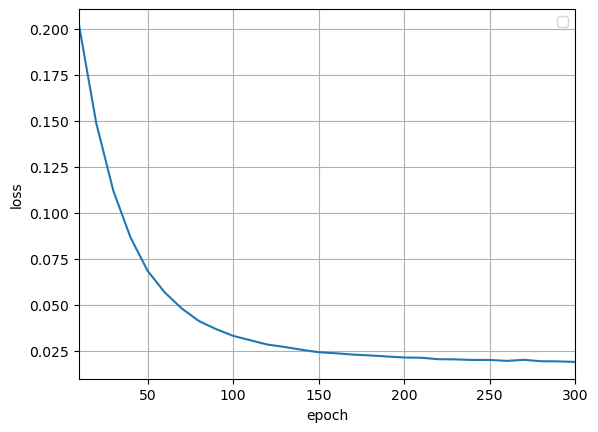

In [167]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 300, torch.device('cpu')

train_iter, src_vocab, tgt_vocab = load_data_nmt(batch_size, num_steps)
encoder = Seq2SeqEncoder(len(src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqDecoder(len(tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
net = EncoderDecoder(encoder, decoder)
train(net, train_iter, lr, num_epochs, tgt_vocab, device)

## 预测

In [168]:
def predict(net, src_sentence, src_vocab, tgt_vocab, num_steps, device, save_attention_weights=False):
    """序列到序列模型的预测"""
    ## 在预测时把net置为评估模式
    net.eval()
    src_tokens = src_vocab[src_sentence.lower().split(' ')]+[src_vocab['<eos>']]
    enc_valid_len = torch.tensor([len(src_tokens)], device=device)
    src_tokens = truncate_pad(src_tokens, num_steps, src_vocab['<pad>'])
    ## 添加批量维度
    enc_X = torch.unsqueeze(
        torch.tensor(src_tokens, dtype=torch.long, device=device), 
        dim=0
    )
    enc_outputs = net.encoder(enc_X, enc_valid_len)
    dec_state = net.decoder.init_state(enc_outputs, enc_valid_len)
    ## 添加批量维度
    dec_X = torch.unsqueeze(
        torch.tensor([tgt_vocab['<bos>']], dtype=torch.long, device=device),
        dim = 0
    )
    output_seq, attention_weight_seq = [], []
    for _ in range(num_steps):
        Y, dec_state = net.decoder(dec_X, dec_state)
        dec_X = Y.argmax(dim=2)
        pred = dec_X.squeeze(dim=0).type(torch.int32).item()
        if save_attention_weights:
            attention_weight_seq.append(net.decoder.attention_weights)
        if pred == tgt_vocab['<eos>']:
            break
        output_seq.append(pred)
    return ' '.join(tgt_vocab.to_tokens(output_seq)), attention_weight_seq

In [169]:
def bleu(pred_seq, label_seq, k):
    """计算bleu"""
    pred_tokens, label_tokens = pred_seq.split(' '), label_seq.split(' ')
    len_pred, len_label = len(pred_tokens), len(label_tokens)
    score = math.exp(min(0, 1-len_label/len_pred))
    for n in range(1, k+1):
        num_matches, label_subs = 0, collections.defaultdict(int)
        for i in range(len_label-n+1):
            label_subs[' '.join(label_tokens[i:i+n])] += 1
        for i in range(len_pred-n+1):
            if label_subs[' '.join(pred_tokens[i:i+n])] > 0:
                num_matches += 1
                label_subs[' '.join(pred_tokens[i:i+n])] -= 1
        score *= math.pow(num_matches / (len_pred-n+1), math.pow(0.5, n))
    return score

In [170]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, _ = predict(
        net, eng, src_vocab, tgt_vocab, num_steps, device
    )
    print(f'{eng} => {translation}, bleu {bleu(translation, fra, k=2):.3f}')

go . => va !, bleu 1.000
i lost . => j'ai perdu ., bleu 1.000
he's calm . => <unk> tomber ., bleu 0.000
i'm home . => je suis faible je suis <unk> ., bleu 0.418


## Exercises

1. 试着通过调整超参数来改善翻译效果

2. 重新运行实验并在计算损失时不使用遮蔽，可以观察到什么结果？为什么会有这个结果？

3. 如果编码器和解码器的层数或者隐藏单元数不同，那么如何初始化解码器的隐状态？

4. 在训练中，如果用前一时间步的预测输入到解码器来代替强制教学，对性能有何影响？

5. 用长短期记忆网络替换门控循环单元重新运行实验

6. 有没有其他方法来设计解码器的输出层？